# Statistical Learning: Mars image classification

### Author: Oussama DIAI

## Dataset exploration (EDA):

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data
train_data = pd.read_csv('mars_train.csv', header=None)
unknown_data = pd.read_csv('mars_unknown.csv', header=None)

In [2]:
train_data.isna().sum()

0       0
1       0
2       0
3       0
4       0
       ..
3596    0
3597    0
3598    0
3599    0
3600    0
Length: 3601, dtype: int64

No NaN values as we can see.

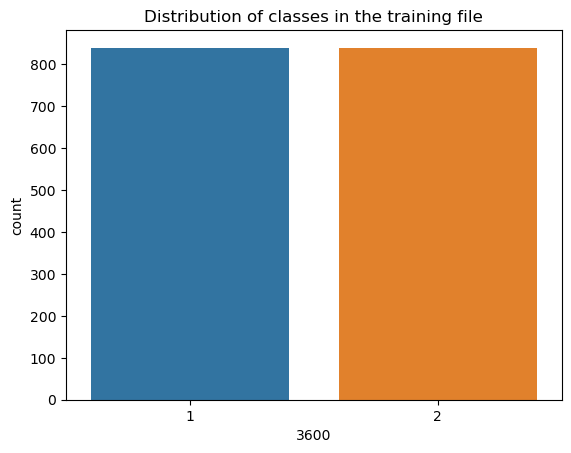

In [3]:
# Check if classes are unbalanced
sns.countplot(x=train_data.columns[-1], data=train_data)
plt.title('Distribution of classes in the training file')
plt.show()

We can see that the dataset is perfectly balanced.

In [4]:
train_data.shape

(1680, 3601)

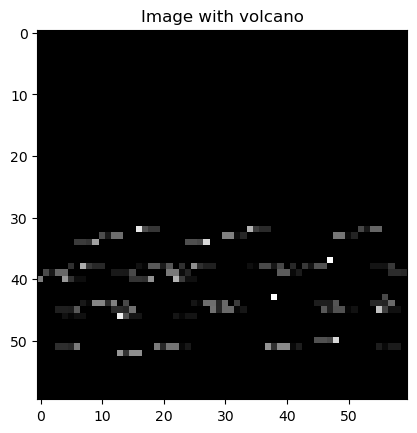

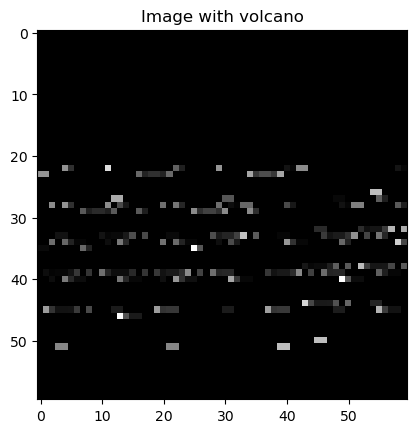

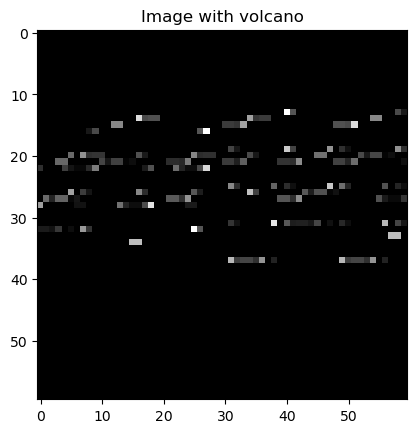

In [5]:
# Print a few images with volcanos
for _, row in train_data[train_data.iloc[:, -1] == 2].sample(3).iterrows():
    # We assume that all columns except the last are image data
    image_data = row.iloc[:-1].values.reshape((60, 60))  # Adjusting the image size according to your data
    plt.imshow(image_data, cmap='gray')  # Assuming the images are grayscale.
    plt.title('Image with volcano')
    plt.show()

In [6]:
# preparation of training data
X = train_data.iloc[:, :-1]  # Characteristics (all columns except the last)
y = train_data.iloc[:, -1]   # Classes (last column) = either 1 or 2

print(X.shape)
print(y.shape)

(1680, 3600)
(1680,)


In [7]:
print(X.describe())
zero_counts = (X == 0).sum()
print(zero_counts)

         0            1            2           3           4            5     \
count  1680.0  1680.000000  1680.000000  1680.00000  1680.00000  1680.000000   
mean      0.0     0.018145     0.006048     0.01039     0.01039     0.002778   
std       0.0     0.079700     0.026567     0.05254     0.05254     0.016160   
min       0.0     0.000000     0.000000     0.00000     0.00000     0.000000   
25%       0.0     0.000000     0.000000     0.00000     0.00000     0.000000   
50%       0.0     0.000000     0.000000     0.00000     0.00000     0.000000   
75%       0.0     0.000000     0.000000     0.00000     0.00000     0.000000   
max       0.0     0.698540     0.232850     0.57735     0.57735     0.214290   

              6       7            8       9     ...         3590    3591  \
count  1680.000000  1680.0  1680.000000  1680.0  ...  1680.000000  1680.0   
mean      0.008334     0.0     0.016758     0.0  ...     0.010689     0.0   
std       0.048480     0.0     0.074792     0.0 

### Reducing the number of features with PCA:

In [8]:
from sklearn.decomposition import PCA

# Perform PCA to keep 99% of the explained variance
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)

# Create a new DataFrame with the principal components and target variable
df_pca = pd.DataFrame(data=X_pca, columns=[f'Principal Component {i+1}' for i in range(X_pca.shape[1])])
df_pca['Target'] = y

In [9]:
df_pca.shape

(1680, 779)

In [10]:
zero_counts_pca = (df_pca == 0).sum()
print(zero_counts_pca)

Principal Component 1      0
Principal Component 2      0
Principal Component 3      0
Principal Component 4      0
Principal Component 5      0
                          ..
Principal Component 775    0
Principal Component 776    0
Principal Component 777    0
Principal Component 778    0
Target                     0
Length: 779, dtype: int64


As we can see, using PCA that keeps 99% of the explained variance, eliminates most zero values.

## Creating our models:

We'll be using SVM and Random Forest. So we'll have to first find the best hyperparameters for these models that are tuned to our dataset.

### SVM:

In [11]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import svm

# Define the hyperparameter grid to explore
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.01, 0.1, 1]}

# Initialize the SVM classifier
svm_classifier = svm.SVC()

# Initialize grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# Perform grid search with cross-validation
grid_search.fit(X, y)

# Show the best hyperparameters found
print("Best hyperparameters :", grid_search.best_params_)

# Evaluate performance with cross-validation on the best hyperparameters
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5)
print("Average accuracy with best hyperparameters :", np.mean(cv_scores))

Best hyperparameters : {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Average accuracy with best hyperparameters : 0.8803571428571428


### Random Forest:

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid to explore for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Perform grid search with cross-validation
grid_search.fit(X, y)

# Show the best hyperparameters found
print("Best hyperparameters :", grid_search.best_params_)

# Evaluate performance with cross-validation on the best hyperparameters
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5)
print("Average accuracy with best hyperparameters :", np.mean(cv_scores))


Best hyperparameters : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Average accuracy with best hyperparameters : 0.8285714285714286


## Creating and training our Pipeline:

In [13]:
# Import necessary libraries
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),             # Standardize features
    ('pca', PCA(n_components=0.99)),          # Use PCA for feature selection
    ('ensemble', VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svm', SVC(kernel='poly', C=1.0, gamma=0.1, probability=True))
        ],
        voting='soft'  # Use majority voting
    ))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8244047619047619


In [14]:
pipeline.fit(X,y)

final_prediction = pipeline.predict(unknown_data)
print(final_prediction)

[1 2 1 1 2 2 2 1 2 2 1 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1 1 2 1 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 1 2 1 1 1 2 2 1 1 2 2 2 2 1 1 2 1 2 2 1 2 1 1 1 2 2 1 1 2 1
 1 1 2 2 2 2 1 2 2 2 2 2 1 2 1 1 2 2 1 1 1 1 2 2 1 2 1 2 1 2 2 1 1 1 1 1 2
 1 1 2 2 1 2 1 2 2 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 1 1 2 1 1 1 2 2 2 2 1
 2 2 2 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 2 2 1 1 1 1 1 1 1 1 2
 2 1 1 2 2 2 1 1 2 1 2 2 1 2 1 1 2 2 1 1 2 2 1 2 1 2 1 2 2 1 2 1 2 1 2 2 1
 1 1 1 2 1 2 2 2 1 1 2 2 1 1 1 1 2 1 1 2 2 1 2 2 2 1 1 2 2 2 2 1 1 1 2 1 1
 1 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 2 2 2 1 1 1 1 2 1 1 2 1 1 1 1 2 1 2 1 1 2
 2 1 1 1 1 1 2 1 2 2 1 1 1 2 1 2 1 2 2 2 1 1 1 1 2 2 1 2 1 1 2 1 1 2 2 1 1
 2 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 1 2 1 2 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 1 1
 1 1 1 2 2 2 1 2 1 1 2 1 2 2 2 1 1 1 2 2 2 1 2 1 1 1 1 2 1 2 1 1 1 1 1 2 2
 1 2 1 1 2 2 2 1 1 2 1 2 2]


In [15]:
df_prediction = pd.DataFrame(final_prediction)
# Save the DataFrame to a CSV file without index nor header
df_prediction.to_csv('predictions.csv', index=False, header=False)